In [1]:
import numpy as np
import pandas as pd                  # data processing, CSV 
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from subprocess import check_output  #defined below
import time                         #helper libraries
from numpy import newaxis


Using TensorFlow backend.


In [2]:
data = pd.read_csv('Google.csv')
data.head()                                


,Date,Open,High,Low,Close,Volume
0,29-Dec-17,1055.49,1058.05,1052.70,1053.40,1180340
1,28-Dec-17,1062.25,1064.84,1053.38,1055.95,994249
2,27-Dec-17,1066.60,1068.27,1058.38,1060.20,1116203
3,26-Dec-17,1068.64,1068.86,1058.64,1065.85,918767
4,22-Dec-17,1070.00,1071.72,1067.64,1068.86,889446


In [3]:
cl = data['Close']
scl = MinMaxScaler()
#Scale the data
cl = cl.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
cl


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


array([[ 0.96344193],
       [ 0.96638365],
       [ 0.97128651],
       ..., 
       [ 0.09941858],
       [ 0.10850907],
       [ 0.11010106]])

In [4]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)


In [5]:
X,y = processData(cl,10)
X_train,X_test = X[:int(X.shape[0]*0.70)],X[int(X.shape[0]*0.70):]
y_train,y_test = y[:int(y.shape[0]*0.70)],y[int(y.shape[0]*0.70):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])


1400
601
1400
601


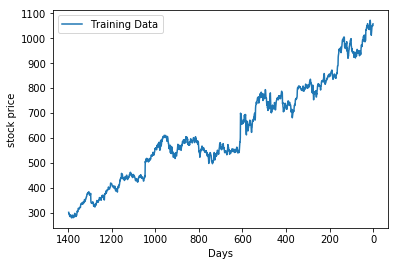

In [6]:
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)))
plt.gca().invert_xaxis()
plt.xlabel('Days')
plt.ylabel('stock price')
plt.legend(['Training Data'])
plt.show()


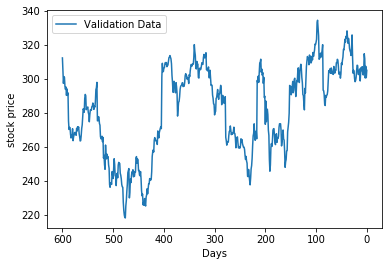

In [7]:
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.gca().invert_xaxis()
plt.xlabel('Days')
plt.ylabel('stock price')
plt.legend(['Validation Data'])
plt.show()


In [8]:
model = Sequential()
model.add(LSTM(512,input_shape=(10,1)))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),shuffle=False)



Train on 1400 samples, validate on 601 samples
Epoch 1/5
1400/1400 [==============================] - 22s 16ms/step - loss: 0.0325 - val_loss: 0.0011
Epoch 2/5
1400/1400 [==============================] - 17s 12ms/step - loss: 0.0045 - val_loss: 5.0188e-04
Epoch 3/5
1400/1400 [==============================] - 18s 13ms/step - loss: 0.0048 - val_loss: 2.3736e-04
Epoch 4/5
1400/1400 [==============================] - 17s 12ms/step - loss: 0.0032 - val_loss: 1.9979e-04
Epoch 5/5
1400/1400 [==============================] - 22s 16ms/step - loss: 0.0018 - val_loss: 1.4887e-04


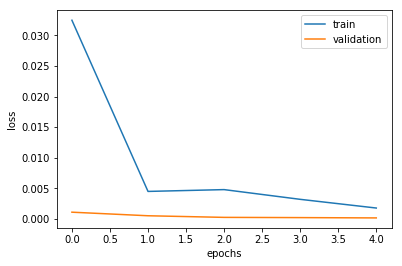

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()



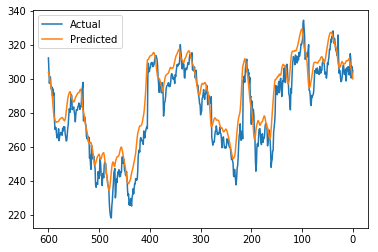

In [10]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))
plt.legend(['Actual','Predicted'])
plt.gca().invert_xaxis()
plt.show()


In [11]:
act = []
pred = []
#for i in range(382):
i=250
Xt = model.predict(X_test[i].reshape(1,10,1))
print('Predicted Price:{0}, Actual Price:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
pred.append(scl.inverse_transform(Xt))
act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))


Predicted Price:[[ 270.4982605]], Actual Price:[[ 259.32]]


In [12]:
def plot_results_multiple(predicted_data, true_data, length):
    plt.plot(scl.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scl.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.gca().invert_xaxis()
    plt.show()


[[ 0.90011585]]
[[ 0.89845204]]
[[ 0.89643735]]
[[ 0.89466041]]
[[ 0.89066446]]
[[ 998.50640869]
 [ 997.06414795]
 [ 995.31768799]
 [ 993.77740479]
 [ 990.31359863]]


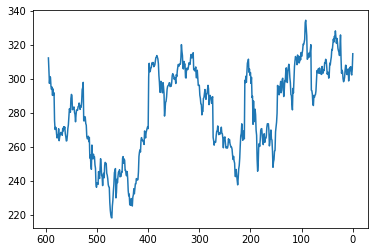

In [13]:
def predict_sequences_multiple(model,firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, X_train[0], predict_length)
print(scl.inverse_transform(np.array(predictions).reshape(-1,1)))
plot_results_multiple(predictions, y_test, predict_length)



